In [24]:
import glob 
import sys 
sys.path.append('..')
from print_results import get_stats
import matplotlib.pyplot as plt 
import numpy as np 

In [25]:
to_search = {
    'lanl': {
        'static': '../results/rw/lanl14argus/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/lanl14argus/snapshot-ft_results_snapshot_bert*.txt'
    }, 
    'unsw': {
        'static': '../results/rw/unsw/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/unsw/snapshot-ft_results_snapshot_bert*.txt'
    },
    'optc': { # Stupidly used a different naming convention for CLS finetuning
        'static': '../results/ft/optc/static_results_snapshot_bert*.txt', 
        'temporal': '../results/ft/optc/rwft_results_snapshot_bert*.txt', 
    },
    'optc-gfm': { # Can't really define how well an untrained cls model does, but can compare to 
                  # non-finetuned LP models did 
        'static': '../results/rw/optc/snapshot-ft_results_snapshot_bert_static*.txt', 
        'temporal': '../results/trw/optc/snapshot-ft_results_snapshot_bert*.txt'

    }
}

results = dict() 
for dataset,temporal_map in to_search.items(): 
    results[dataset] = dict()
    
    for isTemporal,search in temporal_map.items(): 
        nft,auc,ap = get_stats(glob.glob(search))
        results[dataset][isTemporal] = {
            'finetuned': auc[['tiny_auc', 'tiny_ap']].sort_index(inplace=False),
            'base': nft[['tiny_auc', 'tiny_ap']].sort_index(inplace=False)
        }

In [26]:
print(results['lanl']['static']['finetuned'])

    tiny_auc   tiny_ap
0   0.994084  0.112986
1   0.988278  0.096232
2   0.995267  0.139263
4   0.997007  0.235759
6   0.993631  0.146756
8   0.993598  0.125998
10  0.000000  0.000000


[[0.36575247 0.44705067]
 [0.48207036 0.41227544]
 [0.96599737 0.99186174]
 [0.70264544 0.99375616]
 [0.08525448 0.23575869]
 [0.0073923  0.19846643]]


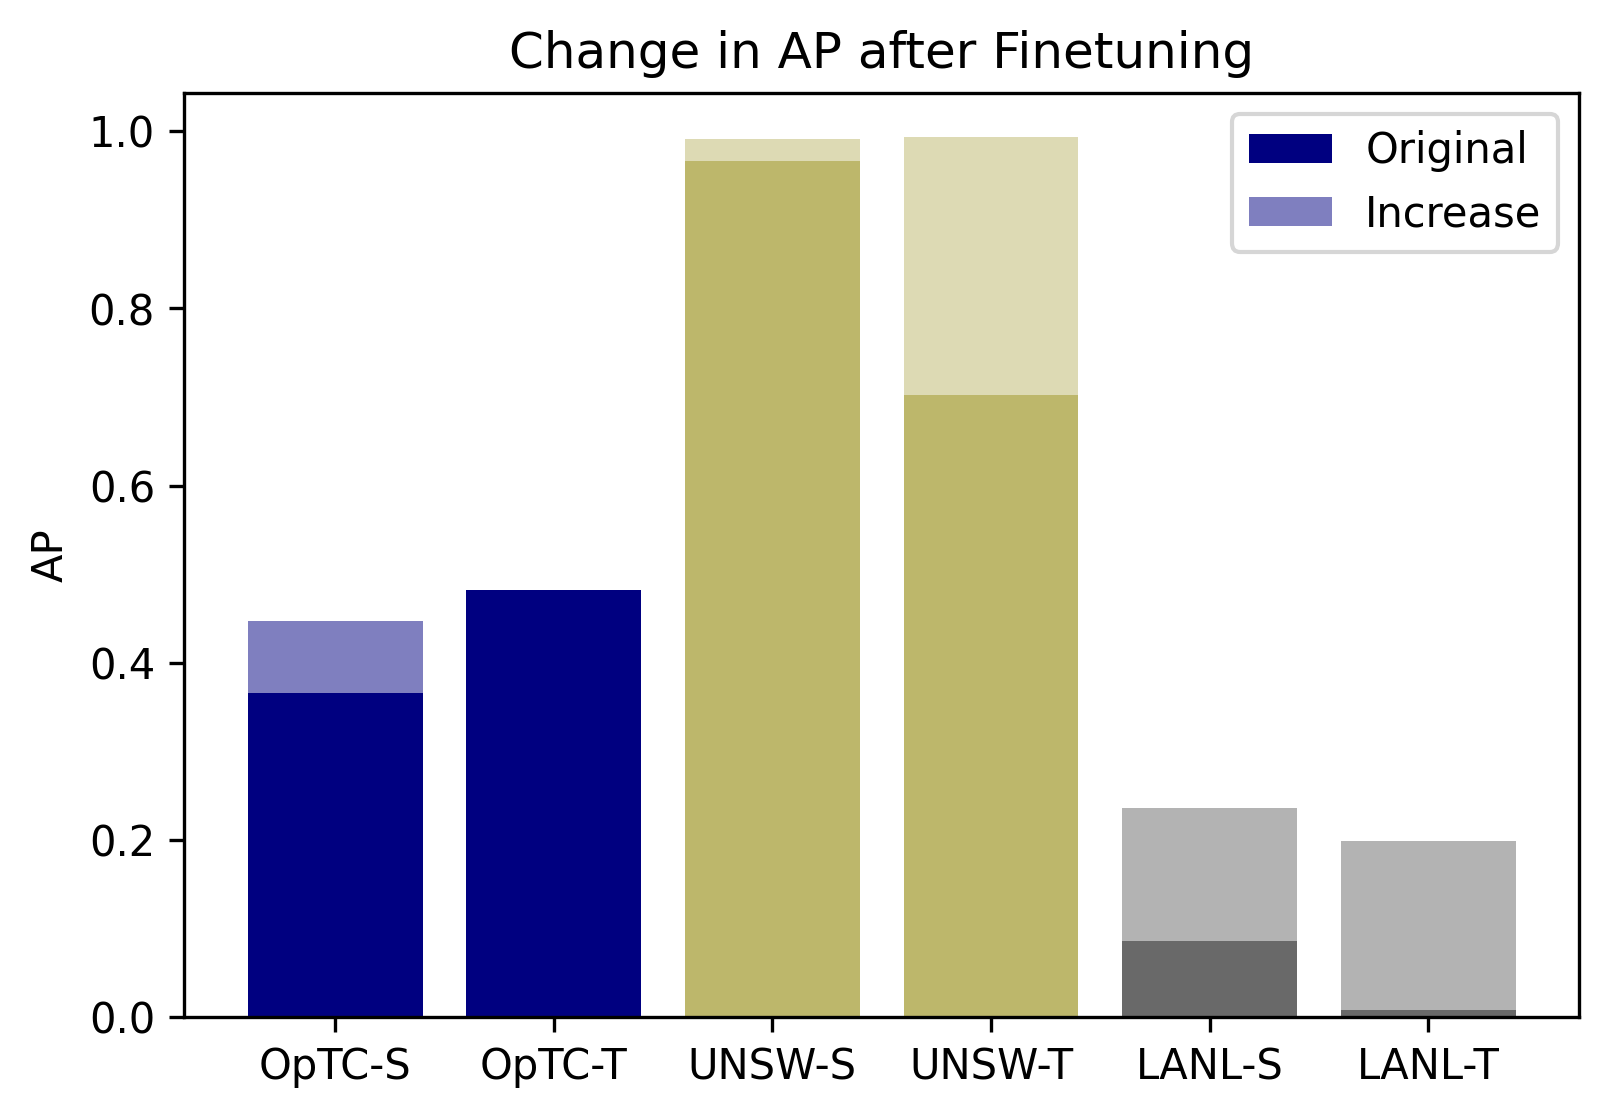

In [58]:
before_after = []
labels = []

dataset = 'lanl'
temp = 'static'

label_map = {
    'optc-gfm': 'OpTC',
    'optc': 'OpTC',
    'unsw': 'UNSW', 
    'lanl': 'LANL', 
    'static': 'S',
    'temporal': 'T'
}

for dataset in ['optc-gfm', 'unsw', 'lanl']: 
    for temp in ['static', 'temporal']:
        dfs = results[dataset][temp]
        best_wl = dfs['finetuned'].idxmax()['tiny_ap']
        ft_ap = dfs['finetuned'].loc[best_wl, 'tiny_ap']

        #if dataset != 'optc': 
        #    gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        #else: 
        #    gfm_ap = results['optc-gfm'][temp]['base'].loc[best_wl, 'tiny_ap']
        gfm_ap = dfs['base'].loc[best_wl, 'tiny_ap']
        
        before_after.append([gfm_ap, ft_ap])
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

data = np.array(before_after)
original = data[:, 0]
new = data[:, 1]

colors = ['navy', 'navy', 'darkkhaki', 'darkkhaki', 'dimgray', 'dimgray']

# Create x positions
x = np.arange(len(data))

plt.figure(figsize=(6, 4), dpi=300)

# Plot stacked bars
plt.bar(x, original, label="Original", color=colors)
plt.bar(x, new - original, bottom=original, label="Increase", color=colors, alpha=0.5)

# Format chart
plt.xticks(x, labels)
plt.ylabel("AP")
plt.title("Change in AP after Finetuning")
plt.legend()

print(data)

plt.show()

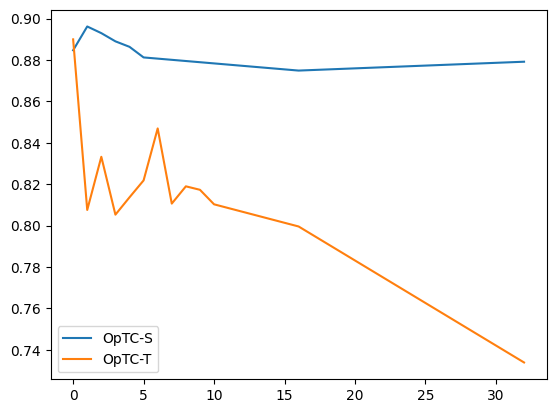

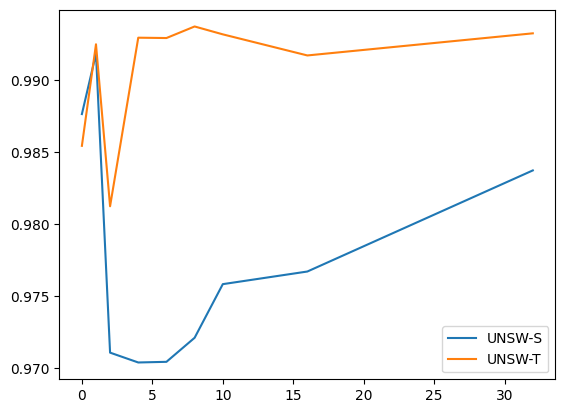

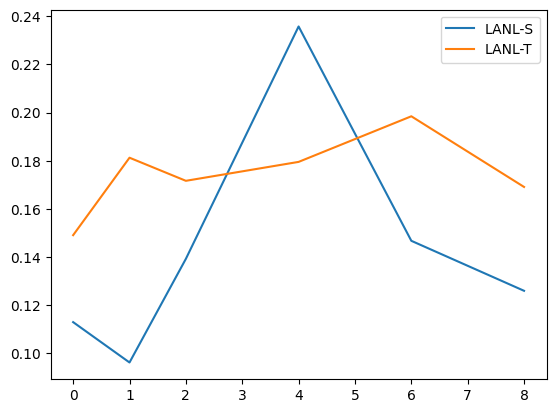

In [55]:
walk_to_ap = []
labels = []

for dataset in ['optc', 'unsw', 'lanl']: 
    for temp in ['static', 'temporal']: 
        df = results[dataset][temp]['finetuned']
        wta = df.reset_index()[['index', 'tiny_ap']].to_numpy()
        wta = wta[wta[:,1] != 0]
        
        walk_to_ap.append(wta)
        labels.append(f'{label_map[dataset]}-{label_map[temp]}')

    for i in range(len(walk_to_ap)): 
        wta = walk_to_ap[i]
        label = labels[i]

        plt.plot(wta[:,0], wta[:,1], label=label)

    walk_to_ap = []
    labels = []

    plt.legend() 
    plt.show()